# Mean Force Integration

The aim of this notebook is to provide examples, as how to run metadynamics simulations, analyse them with MFI and use other useful features.
The layout of this notebook is as follows:

A: Simulations on Alanine Dipeptide

    (1) - Analysing a metadynamics simulations with MFI
    (2) - Running a new simulation and patching (1) and (2) together
    (3) - Running a new simulation with a harmonic potential and patching (1) and (3) together 

B: Simulations on Bjola Potential

    (1) - Running a metadynamics simulation and analyse with MFI
    (2) - Running 10 short simulations (each 1/10 the length of (1), and patch togehter with MFI)
    ###(3) - Running a new simulation with a harmonic potential and patching (1) and (3) together ### Maybe repetitive###

C: Simulations on Invernizzi Potential

    (1) - Running a metadynamics simulation and analyse with MFI
    (2) - Running multiple short simulations, patch togehter with MFI, and determine bootstrap error


In [1]:
import os
import numpy as np
os.chdir("/home/antoniu/Desktop/MFI_git/MFI_master/MFI")
from pyMFI import MFI
from pyMFI import run_plumed
import pickle
import matplotlib.pyplot as plt

results_path = "/home/antoniu/Desktop/MFI_git/MFI_master/MFI/results_plot"
path_data = "/home/antoniu/Desktop/MFI_git/MFI_master/MFI/AlanineDipeptide_pyMFI"

path = os.getcwd()
print("The path to this notebook is:", path)

The path to this notebook is: /home/antoniu/Desktop/MFI_git/MFI_master/MFI


## A: Alanine Dipeptide | 2D periodic CV space example.

#### (1) - Analysing an existing metadynamics simulations with MFI.

A metadynaics simulation was already conducted. The resulting trajectory as CV's coordinates are saved in the file "positon0" and the corresponding HILLS file is saved as "HILLS0".

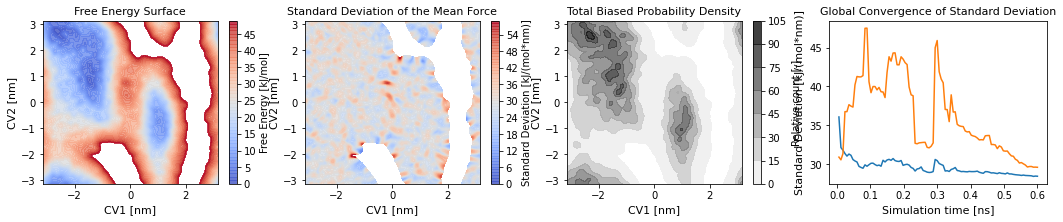

In [5]:
os.chdir("/home/antoniu/Desktop/MFI_git/MFI_master/MFI/AlanineDipeptide_pyMFI")

# #simulations steps for new simulation.
# simulation_steps = 300000

# #prepare new input files
# run_plumed.find_alanine_dipeptide_input(initial_position_x=0.0, initial_position_y=0.0, file_extension="_1sim")

# #Run Alanine dipeptide simulation
# run_plumed.run_alanine_dipeptide(simulation_steps, temperature=2.49, gaus_width_x=0.1, gaus_width_y=0.1, gaus_height=3, biasfactor=20, gaus_pace=100, file_extension="_1sim")

# #Read the HILLS file
HILLS=MFI.load_HILLS_2D(hills_name="HILLS_1sim")

# #Read the Colvar File
[position_x, position_y] = MFI.load_position_2D(position_name="position_1sim")

# #Compute the time-independent mean force
results = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = 0.1, kT = 2.49, log_pace = 10, error_pace = 100, WellTempered=1, nhills=-1, periodic=1, window_corners=[-0.5, 0.5, -1.5, 1.5], FES_cutoff=50)
[X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, ofv_history, ofe_history, ofe_history_window, time_history, Ftot_den2, ofv_num_x, ofv_num_y] = results

# #integration with the FFT method
[X, Y, FES] = MFI.FFT_intg_2D(Ftot_x, Ftot_y)

# Plot Recap
MFI.plot_recap_2D(X, Y, MFI.zero_to_nan(FES*cutoff), MFI.zero_to_nan(Ftot_den*cutoff), MFI.zero_to_nan(ofe*cutoff), ofe_history, time_history, FES_lim=50, ofe_map_lim=60)

plt.plot([time/1000 for time in time_history], ofe_history_window, label="ofe of window")


In [6]:
# #Load Force terms
# [X, Y, FES, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, ofv_history, ofe_history, ofe_history_window, time_history, Ftot_den2, ofv_num_x, ofv_num_y] = MFI.load_pkl(results_path + "/alanine_dipeptide_300K.pkl")

#rename old results
Froce_terms_old = [Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y]
ofe_history_old = ofe_history
ofe_history_window_old = ofe_history_window
ofe_history_time_old = time_history

# Save Force terms
results_1sim = [X, Y, FES, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, ofv_history, ofe_history, ofe_history_window, time_history, Ftot_den2, ofv_num_x, ofv_num_y]
MFI.save_pkl(results_1sim, results_path + "/alanine_dipeptide_300K.pkl")

#### (2) - Running a new simulation and patching (1) and (2) together

Requires that simulation (1) has already been analysed and the force terms and error progression to be saved in the Froce_terms_old and ofe_history_old list.

Total no. of Gaussians analysed: 3000
|300/3000|==> Average Mean Force Error: 28.569531222929935
ofe_window 30.03643168927285
|600/3000|==> Average Mean Force Error: 28.960877213427388
ofe_window 30.064209756843457
|900/3000|==> Average Mean Force Error: 28.954438826530794
ofe_window 30.024346129346632
|1200/3000|==> Average Mean Force Error: 29.039461755736706
ofe_window 30.11216432815827
|1500/3000|==> Average Mean Force Error: 29.348945958139286
ofe_window 30.137223243648766
|1800/3000|==> Average Mean Force Error: 29.521077008251876
ofe_window 30.231219534572368
|2100/3000|==> Average Mean Force Error: 29.573314534359312
ofe_window 30.409230900224994
|2400/3000|==> Average Mean Force Error: 29.72717146947189
ofe_window 30.49281418823377
|2700/3000|==> Average Mean Force Error: 29.74477318165213
ofe_window 30.421997339305467
|3000/3000|==> Average Mean Force Error: 29.66715276620157
ofe_window 30.262762388945717


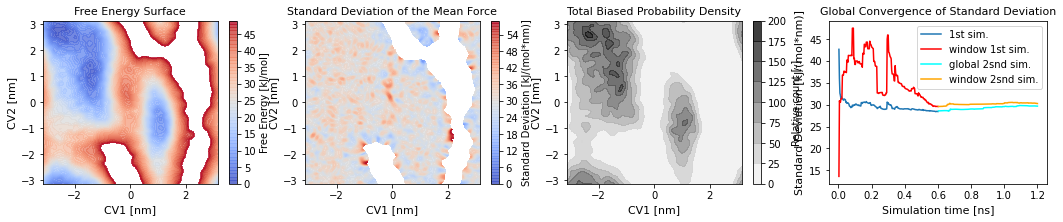

In [4]:
# #simulations steps for new simulation. Same as before.
simulation_steps = 300000

# #prepare new input files
# run_plumed.find_alanine_dipeptide_input(initial_position_x=1.0, initial_position_y=-1.0, file_extension="_2sim")

# #Run Alanine dipeptide simulation
# run_plumed.run_alanine_dipeptide(simulation_steps, temperature=2.49, gaus_width_x=0.1, gaus_width_y=0.1, gaus_height=3, biasfactor=20, gaus_pace=100, file_extension="_2sim")

#Read the HILLS file
HILLS=MFI.load_HILLS_2D(hills_name="HILLS_2sim")

#Read the Colvar File
[position_x, position_y] = MFI.load_position_2D(position_name="position_2sim")

# Compute the time-independent mean force
results = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = 0.1, kT = 2.49, periodic=1, log_pace = 10, error_pace = 200, WellTempered=1, nhills=-1, window_corners=[-0.5, 0.5, -1.5, 1.5], FES_cutoff=50, base_terms = Froce_terms_old)
[X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, ofv_history, ofe_history, ofe_history_window, time_history, Ftot_den2, ofv_num_x, ofv_num_y] = results


#Patch results
patch = MFI.patch_2D([Froce_terms_old, [Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y]])
time_history = [element+ofe_history_time_old[-1] for element in time_history]


#integration with the FFT method
[X, Y, FES] = MFI.FFT_intg_2D(patch[2], patch[3])

# Plot Recap
MFI.plot_recap_2D(X, Y, FES, patch[0], ofe, ofe_history_old, ofe_history_time_old, FES_lim=50, ofe_map_lim=60)
plt.plot(0, np.nan, c="C0", label="1st sim.")
plt.plot([time/1000 for time in ofe_history_time_old], ofe_history_window_old, c="red", label="window 1st sim.")
plt.plot([time/1000 for time in time_history], ofe_history, c="cyan", label="global 2snd sim.")
plt.plot([time/1000 for time in time_history], ofe_history_window, c="orange", label="window 2snd sim.")
plt.legend()
plt.legend()
plt.show()

# # Save Force terms
# Ftot_master = [X, Y, Ftot_den, FES, patch[0], ofe, ofe_history_old[0], ofe_history_old[1], time_history, ofe_history]
# with open(results_path + "/alanine_dipeptide_patch2.pkl","wb") as fw:
#     pickle.dump(Ftot_master, fw)

#### (3) - Running a new simulation with a harmonic potential and patching (1) and (3) together

Requires that simulation (1) has already been analysed and the force terms and error progression to be saved in the Froce_terms_old and ofe_history_old list.



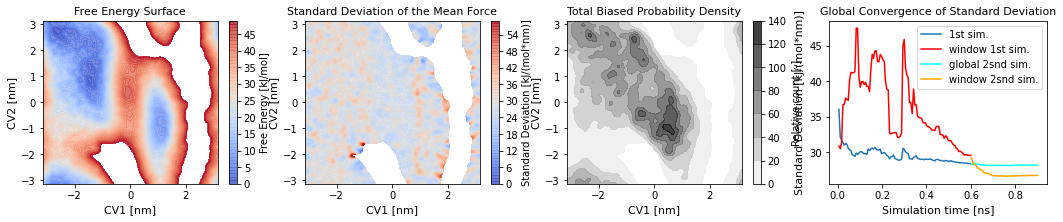

In [8]:
path_data = "/home/antoniu/Desktop/MFI_git/MFI_master/MFI/AlanineDipeptide_pyMFI"
os.chdir(path_data)

simulation_steps = 150000
kappa_x = 100

# #prepare new input files
# run_plumed.find_alanine_dipeptide_input(initial_position_x=0.5, initial_position_y=1.0, file_extension="_static")

# # #Run Alanine dipeptide simulation
# run_plumed.run_alanine_dipeptide(simulation_steps, temperature=2.49, gaus_width_x=0.1, gaus_width_y=0.1, gaus_height=1, biasfactor=20, gaus_pace=100, hp_centre_x=0.0, hp_centre_y=0.0, hp_kappa_x=kappa_x, hp_kappa_y=0, file_extension="_static")

#Read the HILLS file
HILLS=MFI.load_HILLS_2D(hills_name=path_data + "/HILLS" + "_static")

#Read the Colvar File
[position_x, position_y] = MFI.load_position_2D(position_name=path_data + "/position" + "_static")

# Compute the time-independent mean force
results = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = 0.1, kT = 2.49, periodic=1, log_pace = 5, error_pace = 100, WellTempered=1, nhills=-1, window_corners=[-0.5, 0.5, -1.5, 1.5], FES_cutoff=50, base_terms = Froce_terms_old, hp_centre_x=0.0, hp_centre_y=0.0, hp_kappa_x=kappa_x, hp_kappa_y=0)
[X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, ofv_history, ofe_history, ofe_history_window, time_history, Ftot_den2, ofv_num_x, ofv_num_y] = results


#Patch results
[Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y] = MFI.patch_2D([Froce_terms_old, [Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y]])
time_history = [element+ofe_history_time_old[-1] for element in time_history]
history_time = [element+ofe_history_time_old[-1] for element in time_history]


#integration with the FFT method
[X, Y, FES] = MFI.FFT_intg_2D(Ftot_x, Ftot_y)

# Plot Recap
MFI.plot_recap_2D(X, Y, MFI.zero_to_nan(FES*cutoff), MFI.zero_to_nan(Ftot_den*cutoff), MFI.zero_to_nan(ofe*cutoff), ofe_history_old, ofe_history_time_old, FES_lim=50, ofe_map_lim=60)
plt.plot(0, np.nan, c="C0", label="1st sim.")
plt.plot([time/1000 for time in ofe_history_time_old], ofe_history_window_old, c="red", label="window 1st sim.")
plt.plot([time/1000 for time in time_history], ofe_history, c="cyan", label="global 2snd sim.")
plt.plot([time/1000 for time in time_history], ofe_history_window, c="orange", label="window 2snd sim.")
plt.legend()
plt.show()

In [10]:
# Save Force terms
results_static = [X, Y, FES, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, ofe_history_old, ofe_history_time_old, ofe_history_window_old, ofe_history, ofe_history_window, time_history, Ftot_den2, ofv_num_x, ofv_num_y]
MFI.save_pkl(results_static, results_path + "/alanine_dipeptide_static_patch.pkl")


## B: Bjola potential | 2D non-periodic example

Analytical function: $z(x,y) = 7*x^4-23*x^2+7*y^4-23*y^2$

#### (1) - Running a metadynamics simulation and analyse with MFI

Total no. of Gaussians analysed: 10000
|1000/10000|==> Average Mean Force Error: 13.854480156983678    ||    Error in window 22.36244482359596
|2000/10000|==> Average Mean Force Error: 14.860314522079998    ||    Error in window 21.67570565722604
|3000/10000|==> Average Mean Force Error: 15.161460623913252    ||    Error in window 17.67067294106601
|4000/10000|==> Average Mean Force Error: 15.42381662639325    ||    Error in window 14.682741416806623
|5000/10000|==> Average Mean Force Error: 15.786508931873888    ||    Error in window 14.945588098070084
|6000/10000|==> Average Mean Force Error: 16.077802033161365    ||    Error in window 14.9142228285953
|7000/10000|==> Average Mean Force Error: 16.3395627061573    ||    Error in window 14.902430121425903
|8000/10000|==> Average Mean Force Error: 16.439053259136138    ||    Error in window 14.896666327141627
|9000/10000|==> Average Mean Force Error: 16.431119323529952    ||    Error in window 14.806780230229476
|10000/10000|==> Average

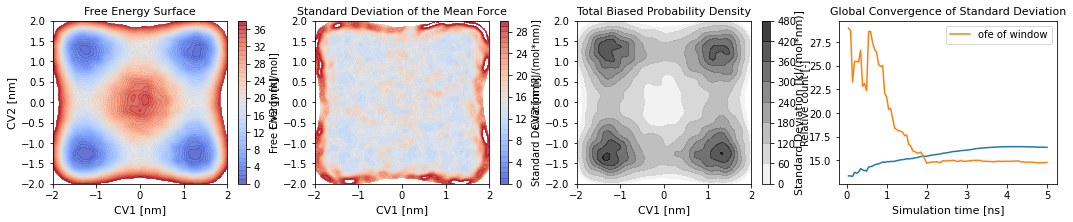

In [6]:
path_bjola = "/home/antoniu/Desktop/MFI_git/MFI_master/MFI/Antoniu_2D_potential"
os.chdir(path_bjola)

# #Run simulation
# run_plumed.run_langevin2D(1000000, gaus_width_x=0.1, gaus_width_y=0.1, gaus_height=2, biasfactor=20, gaus_pace=100, file_extension="_1M")

#Read the HILLS file
HILLS=MFI.load_HILLS_2D(hills_name="HILLS_1M")

#Read the Colvar File
[position_x, position_y] = MFI.load_position_2D(position_name="position_1M")

#Compute the time-independent mean force
[X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, ofv_history, ofe_history, ofe_history_window, time_history, Ftot_den2, ofv_num_x, ofv_num_y] = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = 0.1, kT = 1, min_grid=np.array((-2, -2)), max_grid=np.array((2, 2)), nbins=np.array((200, 200)), log_pace = 10, error_pace = 100, nhills=-1, periodic=0, window_corners=[-0.5, 0.5, -0.5, 0.5], FES_cutoff=38, FFT_integration=1)

#integration on a periodic domain
[X, Y, FES] = MFI.intgrad2(Ftot_x, Ftot_y, min_grid=np.array((-2, -2)), max_grid=np.array((2, 2)))

# Plot Recap
MFI.plot_recap_2D(X, Y, MFI.zero_to_nan(FES*cutoff), MFI.zero_to_nan(Ftot_den*cutoff), MFI.zero_to_nan(ofe*cutoff), ofe_history, time_history, FES_lim=39, ofe_map_lim=31)
plt.plot([time/1000 for time in time_history], ofe_history_window, label="ofe of window")
plt.legend()
plt.show()

In [7]:
#rename old results
Froce_terms_old = [Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y]
ofe_history_old = ofe_history
ofe_history_window_old = ofe_history_window
ofe_history_time_old = time_history

# Save Force terms
results_bjola_pot = [X, Y, FES, cutoff, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, ofv_history, ofe_history, ofe_history_window, time_history, Ftot_den2, ofv_num_x, ofv_num_y]
MFI.save_pkl(results_bjola_pot, results_path + "/bjola_pot_1M.pkl")

max 77.78308418397967
max window 37.77843797950056


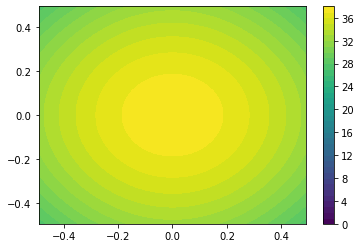

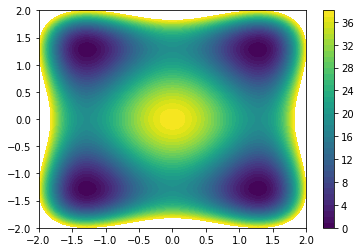

In [30]:
zz = 7 * X ** 4  - 23 * X **2 + 7* Y ** 4  - 23 * Y **2
zz = zz - np.min(zz)
window_corners=[-0.5, 0.5, -0.5, 0.5]

min_grid=np.array((-2, -2))
max_grid=np.array((2, 2))
nbins=np.array((200, 200))
grid_space = np.array(((max_grid[0] - min_grid[0]) / (nbins[0]-1), (max_grid[1] - min_grid[1]) / (nbins[1]-1)))

print("max", np.max(zz))

zz_r = MFI.reduce_to_window(zz, min_grid, grid_space, x_min=window_corners[0], x_max=window_corners[1], y_min=window_corners[2], y_max=window_corners[3])
xx_r = MFI.reduce_to_window(X, min_grid, grid_space, x_min=window_corners[0], x_max=window_corners[1], y_min=window_corners[2], y_max=window_corners[3])
yy_r = MFI.reduce_to_window(Y, min_grid, grid_space, x_min=window_corners[0], x_max=window_corners[1], y_min=window_corners[2], y_max=window_corners[3])
print("max window", np.max(zz_r))



plt.contourf(xx_r,yy_r,zz_r, levels=range(0, 39, 1))
plt.colorbar()
plt.show()

plt.contourf(X,Y,zz, levels=range(0, 39, 1))
plt.colorbar()
plt.show()

In [8]:
[X, Y, FES, cutoff, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, ofv_history, ofe_history, ofe_history_window, time_history, Ftot_den2, ofv_num_x, ofv_num_y] = MFI.load_pkl(results_path + "/bjola_pot_1M.pkl")
Froce_terms_old = [Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y]
ofe_history_old = ofe_history
ofe_history_window_old = ofe_history_window
ofe_history_time_old = time_history

#### (2) - Running 10 short simulations (each 1/10 the length of (1), and patch togehter with MFI)

Simulation: 0  |   |1000/1000|=> Avr OFE: 257.53 ***     ||    Error in window nan
Simulation: 1  |   |1000/1000|=> Avr OFE: 236.23 ***     ||    Error in window nan
Simulation: 2  |   |1000/1000|=> Avr OFE: 225.3 ***     ||    Error in window nan
Simulation: 3  |   |1000/1000|=> Avr OFE: 218.49 ***     ||    Error in window nan
Simulation: 4  |   |1000/1000|=> Avr OFE: 214.19 ***     ||    Error in window nan
Simulation: 5  |   |1000/1000|=> Avr OFE: 210.6 ***     ||    Error in window nan
Simulation: 6  |   |1000/1000|=> Avr OFE: 207.93 ***     ||    Error in window nan
Simulation: 7  |   |1000/1000|=> Avr OFE: 205.16 ***     ||    Error in window nan
Simulation: 8  |   |1000/1000|=> Avr OFE: 203.51 ***     ||    Error in window nan
Simulation: 9  |   |1000/1000|=> Avr OFE: 201.75 ***     ||    Error in window nan


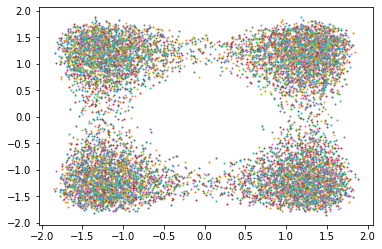

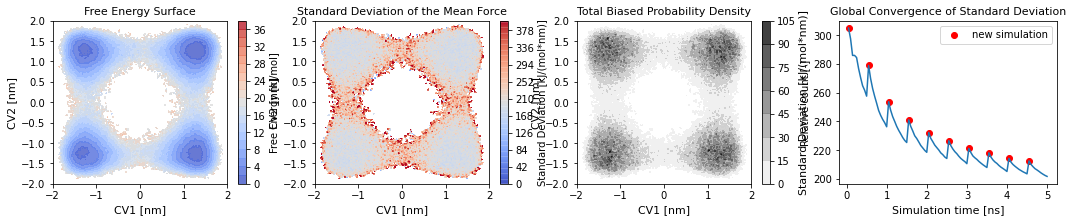

45.978535849639385


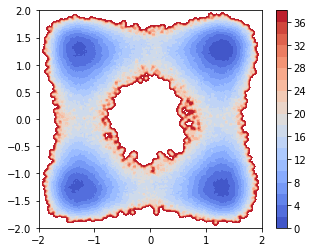

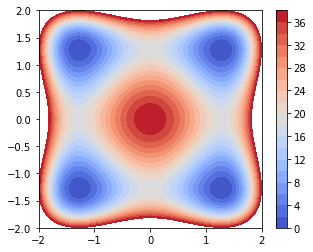

In [4]:
path_bjola = "/home/antoniu/Desktop/MFI_git/MFI_master/MFI/Antoniu_2D_potential"
os.chdir(path_bjola)


simulation_steps = 100000
n_simulations = 10
master = []
master_patch = [[np.zeros((200,200)), np.zeros((200,200)), np.zeros((200,200)), np.zeros((200,200)), np.zeros((200,200)), np.zeros((200,200))]]
ofe_history_patch = [0]
ofe_history_patch_time = [0]
pbt_bandwidth = 0.008


for simulation in np.arange(0,n_simulations): 

    print('Simulation: '+str(simulation), end="  |   ")
    file_extension="_s" + str(int(simulation))
    
    # ipos=1.3*(2 * np.random.rand(2) - 1)
    # #RUN short sim from random location
    # run_plumed.run_langevin2D(simulation_steps, initial_position_x=ipos[0], initial_position_y=ipos[1], gaus_width_x=0.1, gaus_width_y=0.1, gaus_height=2, biasfactor=20, gaus_pace=100, file_extension=file_extension)

    #Read the HILLS and position file file
    HILLS=MFI.load_HILLS_2D(hills_name="HILLS" + file_extension)
    [position_x, position_y] = MFI.load_position_2D(position_name="position" + file_extension)
    plt.scatter(HILLS[:,1],HILLS[:,2], s=1)

    #COMPUTE Mean force and weight of the simulation
    [X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, ofv_history, ofe_history, ofe_history_window, time_history, Ftot_den2, ofv_num_x, ofv_num_y] = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = pbt_bandwidth, kT = 1, min_grid=np.array((-2, -2)), max_grid=np.array((2, 2)), nbins=np.array((200, 200)), log_pace = 1, error_pace = 10, periodic=0, base_terms = master_patch[-1], window_corners=[-0.5, 0.5, -0.5, 0.5], FES_cutoff=38, FFT_integration = 1)
    
    #store results in master_array
    master.append([Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y])
    #patch master and store result in master_patch
    master_patch.append(MFI.patch_2D(master))
    #save ofe history
    ofe_history_patch += ofe_history
    ofe_history_time_adj = [element+ofe_history_patch_time[-1] for element in time_history]
    ofe_history_patch_time += ofe_history_time_adj
    
#find "standard devaition of mean force" map
[ofv, ofe] = MFI.mean_force_variance(master_patch[-1][0], master_patch[-1][1], master_patch[-1][2], master_patch[-1][3], master_patch[-1][4], master_patch[-1][5])

#integration on a periodic domain
[X, Y, FES] = MFI.FFT_intg_2D(master_patch[-1][2], master_patch[-1][3], min_grid=np.array((-2, -2)), max_grid=np.array((2, 2)), nbins=np.array((200, 200)))

# cutoff = np.where(Ftot_den < 10**-5, 0, cutoff)

# Plot Results
#shorten history to remove the first entry
ofe_history_patch = ofe_history_patch[1:]
ofe_history_patch_time = ofe_history_patch_time[1:]
#make "sim_start" list with only the first entry of a simulation
sim_start = [ofe_history_patch_time[i*10] for i in range(n_simulations)]
sim_start_error = [ofe_history_patch[i*10] for i in range(n_simulations)]

# Plot Recap
MFI.plot_recap_2D(X, Y, MFI.zero_to_nan(FES*cutoff), MFI.zero_to_nan(master_patch[-1][0]*cutoff), MFI.zero_to_nan(ofe*cutoff), ofe_history_patch, ofe_history_patch_time, FES_lim=40, ofe_map_lim=int(ofe_history_patch[-1]*2), FES_step=2, ofe_step=3)
plt.scatter([time/1000 for time in sim_start], sim_start_error, c="r", label="new simulation")
plt.legend()
plt.show()

print(np.max(FES))

plt.figure(figsize=(5,4))
plt.contourf(X,Y,FES, cmap='coolwarm', levels=range(0,40,2))
plt.colorbar()

Z = - 23*X**2 + 7*X**4 - 23*Y**2 + 7*Y**4
Z = Z - np.min(Z)

plt.figure(figsize=(5,4))
plt.contourf(X,Y,Z, cmap='coolwarm', levels=range(0,40,2))
plt.colorbar()


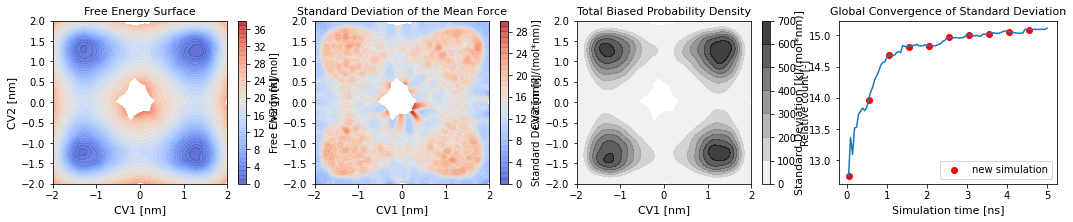

In [5]:
# Save Force terms
results_bjola_pot_multisim = [X, Y, FES, master_patch[-1][0], ofe, ofe_history_patch, ofe_history_patch_time, sim_start, sim_start_error]
MFI.save_pkl(results_bjola_pot_multisim, results_path + "/bjola_pot_multisim.pkl")

# [X, Y, FES, Ftot_den, ofe, ofe_history_patch, ofe_history_patch_time, sim_start, sim_start_error] = MFI.load_pkl(results_path + "/bjola_pot_multisim.pkl")

# # Plot Recap
# MFI.plot_recap_2D(X, Y, MFI.zero_to_nan(FES*cutoff), MFI.zero_to_nan(Ftot_den*cutoff), MFI.zero_to_nan(ofe*cutoff), ofe_history_patch, ofe_history_patch_time, FES_lim=39, ofe_map_lim=31)
# plt.scatter([time/1000 for time in sim_start], sim_start_error, c="r", label="new simulation")
# plt.legend()
# plt.show()

#### (3) - Running a new simulation with a harmonic potential and patching (1) and (3) together

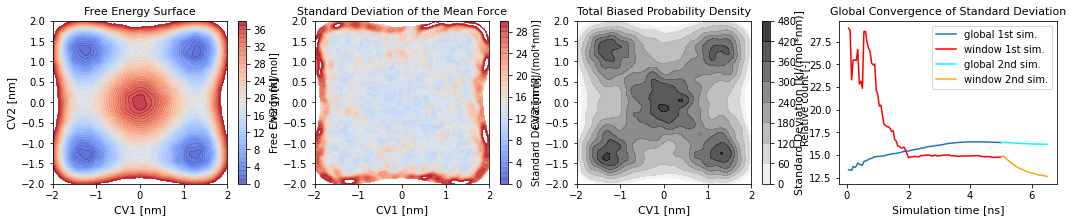

In [15]:
# #Run simulation with Harmonic potential
# run_plumed.run_langevin2D(300000, grid_min_x=-3.0, grid_max_x=3.0, grid_min_y=-3.0, grid_max_y=3.0, grid_bin_x=200, grid_bin_y=200, gaus_width_x=0.1, gaus_width_y=0.1, gaus_height=1, biasfactor=5, gaus_pace=100, hp_centre_x=0.0, hp_centre_y=0.0, hp_kappa_x=50, hp_kappa_y=50, file_extension="BjHP")


#Read the HILLS file
HILLS=MFI.load_HILLS_2D(hills_name="HILLS" + "BjHP")

#Read the Colvar File
[position_x, position_y] = MFI.load_position_2D(position_name="position" + "BjHP")

#Compute the time-independent mean force
[X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, ofv_history, ofe_history, ofe_history_window, time_history, Ftot_den2, ofv_num_x, ofv_num_y] = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, min_grid=np.array((-2, -2)), max_grid=np.array((2, 2)), nbins=np.array((200, 200)), bw = 0.1, kT = 1, log_pace = 5, error_pace = 100, base_terms = Froce_terms_old, window_corners=[-0.5, 0.5, -0.5, 0.5], hp_centre_x=0.0, hp_centre_y=0.0, hp_kappa_x=50, hp_kappa_y=50, FES_cutoff=38, FFT_integration=1)


#Patch results
[Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y] = MFI.patch_2D([Froce_terms_old, [Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y]])
ofe_history_time = [element+ofe_history_time_old[-1] for element in time_history]


#integration on a periodic domain
[X, Y, FES] = MFI.FFT_intg_2D(Ftot_x, Ftot_y, min_grid=np.array((-2, -2)), max_grid=np.array((2, 2)), nbins=np.array((200, 200)))


# Plot Recap
MFI.plot_recap_2D(X, Y, MFI.zero_to_nan(FES*cutoff), MFI.zero_to_nan(Ftot_den*cutoff), MFI.zero_to_nan(ofe*cutoff), ofe_history_old, ofe_history_time_old, FES_lim=39, ofe_map_lim=31)
plt.plot(0, np.nan, c="C0", label="global 1st sim.")
plt.plot([time/1000 for time in ofe_history_time_old], ofe_history_window_old, c="red", label="window 1st sim.")
plt.plot([time/1000 for time in ofe_history_time], ofe_history, c="cyan", label="global 2nd sim.")
plt.plot([time/1000 for time in ofe_history_time], ofe_history_window, c="orange", label="window 2nd sim.")
plt.legend()
plt.show()

[X, Y, FES, cutoff, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, ofe_history_old, ofe_history_window_old, ofe_history_time_old, ofe_history, ofe_history_window, ofe_history_time, Ftot_den2, ofv_num_x, ofv_num_y]

In [16]:
# Save Force terms
results_bjola_pot = [X, Y, FES, cutoff, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, ofe_history_old, ofe_history_window_old, ofe_history_time_old, ofe_history, ofe_history_window, ofe_history_time, Ftot_den2, ofv_num_x, ofv_num_y]
MFI.save_pkl(results_bjola_pot, results_path + "/bjola_pot_static_patch_window.pkl")

## C: Invernizzi Potential | 2D non-periodic example

$z = 1.34549*x^4+1.90211*x^3*y+3.92705*x^2*y^2-6.44246*x^2-1.90211*x*y^3+5.58721*x*y+1.33481*x+1.34549*y^4-5.55754*y^2+0.904586*y+18.5598$

#### (0) - Analytical plot

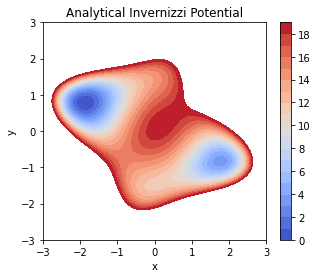

In [1]:
import os
os.chdir("/home/antoniu/Desktop/MFI_git/MFI_master/MFI")
import numpy as np
from pyMFI import MFI
from pyMFI import run_plumed
import pickle
import matplotlib.pyplot as plt

results_path = "/home/antoniu/Desktop/MFI_git/MFI_master/MFI/results_plot"

grid = np.linspace(-3, 3, 200); 
X, Y = np.meshgrid(grid, grid)
inve_pot = 1.34549*X**4+1.90211*X**3*Y+3.92705*X**2*Y**2-6.44246*X**2-1.90211*X*Y**3+5.58721*X*Y+1.33481*X+1.34549*Y**4-5.55754*Y**2+0.904586*Y+18.5598
inve_pot = inve_pot - np.min(inve_pot)

plt.figure(figsize=(5,4)); 
plt.contourf(X, Y, inve_pot, levels=range(0, 20, 1), cmap='coolwarm')
plt.xlabel("x"); plt.ylabel("y"); 
plt.title("Analytical Invernizzi Potential"); 
plt.colorbar()
plt.show()

#### (1) - Running a metadynamics simulation and analyse with MFI

Total no. of Gaussians analysed: 5000
|1000/5000|==> Average Mean Force Error: 9.706970756230874
|2000/5000|==> Average Mean Force Error: 9.500635702324608
|3000/5000|==> Average Mean Force Error: 9.316520482408391
|4000/5000|==> Average Mean Force Error: 9.361360789505053
|5000/5000|==> Average Mean Force Error: 9.376483457391636


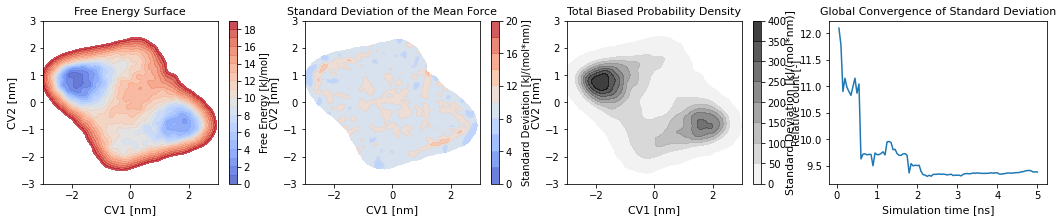

In [8]:
path_data = "/home/antoniu/Desktop/MFI_git/MFI_master/MFI/Invernizzi_2D_potential"
os.chdir(path_data)

#Run simulation
# run_plumed.run_2D_Invernizzi(simulation_steps=1000000, sigma=0.1, height=0.5, biasfactor=10, initial_position_x=-1, initial_position_y=-1, file_extension="long")

#Read the HILLS file
HILLS=MFI.load_HILLS_2D(hills_name="HILLSinve_long")

#Read the Colvar File
[position_x, position_y] = MFI.load_position_2D(position_name="positioninve_long")

#COMPUTE Mean force and weight of the simulation
[X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, ofv_history, ofe_history, time_history, Ftot_den2, ofv_num_x, ofv_num_y] = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = 0.12, kT = 1, min_grid=np.array((-3, -3)), max_grid=np.array((3, 3)), log_pace = 5, error_pace = 100, FES_cutoff = 20)

#integration on a periodic domain
[X, Y, FES] = MFI.intgrad2(Ftot_x, Ftot_y, min_grid=np.array((-3, -3)), max_grid=np.array((3, 3)))

cutoff = np.where(FES <= np.ones_like(FES) * 18, 1, 0)

#Plot results
MFI.plot_recap_2D(X, Y, FES, MFI.zero_to_nan(np.where(Ftot_den > 0.1, Ftot_den, 0)), MFI.zero_to_nan(ofe*cutoff), ofe_history, time_history, FES_lim=20, ofe_map_lim=21, FES_step=1, ofe_step=2)
plt.show()

In [9]:
MFI.save_pkl([X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, ofv_history, ofe_history, time_history, Ftot_den2, ofv_num_x, ofv_num_y], "/home/antoniu/Desktop/MFI_git/MFI_master/MFI/Invernizzi_2D_potential/results_1M.pkl")

# [X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, ofv_history, ofe_history, time_history, Ftot_den2, ofv_num_x, ofv_num_y] = MFI.load_pkl("/home/antoniu/Desktop/MFI_git/MFI_master/MFI/Invernizzi_2D_potential/results_1M.pkl")

#### (2) - Running multiple short simulations, patch togehter with MFI, and determine bootstrap error

Simulation:  0    |   Simulation:  1    |   Simulation:  2    |   Simulation:  3    |   Simulation:  4    |   Simulation:  5    |   Simulation:  6    |   Simulation:  7    |   Simulation:  8    |   Simulation:  9    |   Simulation:  10    |   Simulation:  11    |   Simulation:  12    |   Simulation:  13    |   Simulation:  14    |   Simulation:  15    |   Simulation:  16    |   Simulation:  17    |   Simulation:  18    |   Simulation:  19    |   Simulation:  20    |   Simulation:  21    |   Simulation:  22    |   Simulation:  23    |   Simulation:  24    |   Simulation:  25    |   Simulation:  26    |   Simulation:  27    |   Simulation:  28    |   Simulation:  29    |   Simulation:  30    |   Simulation:  31    |   Simulation:  32    |   Simulation:  33    |   Simulation:  34    |   Simulation:  35    |   Simulation:  36    |   Simulation:  37    |   Simulation:  38    |   Simulation:  39    |   

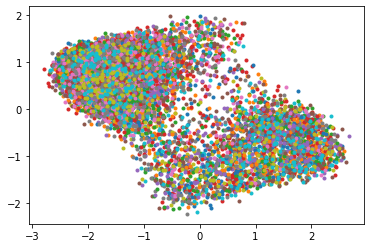

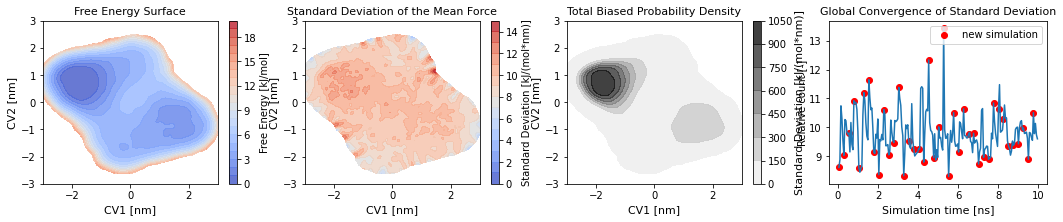

In [2]:
path_data = "/home/antoniu/Desktop/MFI_git/MFI_master/MFI/Invernizzi_2D_potential"
os.chdir(path_data)

forces_all = []

master = []
master_patch = [[np.zeros((200,200)), np.zeros((200,200)), np.zeros((200,200)), np.zeros((200,200)), np.zeros((200,200)), np.zeros((200,200))]]
ofe_history_patch = [0]
time_history_patch = [0]


for simulation in np.arange(0,40):   
    print("Simulation: ", simulation, "   |   " , end="")          
    if os.path.exists(path_data + "/forces_inve_" + str(simulation)) == True:
        #Read the HILLS file for traj plot
        HILLS=MFI.load_HILLS_2D(hills_name="HILLSinve_"+str(simulation))
        plt.plot(HILLS[:,1],HILLS[:,2],'.')
        [X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, ofv_history, ofe_history, time_history, Ftot_den2, ofv_num_x, ofv_num_y] = MFI.load_pkl(path_data + "/forces_inve_" + str(simulation))
    else:
        # #Randomize initial position
        # [initial_position_x, initial_position_y] = 1.3*(2 * np.random.rand(2) - 1)
    
        # #Run simulation
        # run_plumed.run_2D_Invernizzi(simulation_steps=50000, sigma=0.1, height=0.8, biasfactor=10, initial_position_x=initial_position_x, initial_position_y=initial_position_y, file_extension=str(simulation))
                                             
        #Read the HILLS file
        HILLS=MFI.load_HILLS_2D(hills_name="HILLSinve_"+str(simulation))
        # plt.plot(HILLS[:,1],HILLS[:,2],'.')
        
        #Read the Colvar File
        [position_x, position_y] = MFI.load_position_2D(position_name="positioninve_"+str(simulation))
        
        #COMPUTE Mean force and weight of the simulation
        [X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, ofv_history, ofe_history, time_history, Ftot_den2, ofv_num_x, ofv_num_y] = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = 0.12, kT = 1, log_pace = 1, error_pace = 5, nhills=-1, min_grid=np.array((-3, -3)), max_grid=np.array((3, 3)), nbins=np.array((200, 200)), FES_cutoff = 20)
        #save results
        MFI.save_pkl([X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, ofv_history, ofe_history, time_history, Ftot_den2, ofv_num_x, ofv_num_y], path_data + "/forces_inve_" + str(simulation))
        
         
    forces_all.append([X, Y, Ftot_den, Ftot_x, Ftot_y])
    
    #store results in master_array
    master.append([Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y])
    #patch master and store result in master_patch
    master_patch.append(MFI.patch_2D(master))
    #save ofe history
    ofe_history_patch += ofe_history
    time_history_adj = [element+time_history_patch[-1] for element in time_history]
    time_history_patch += time_history_adj
    
    
#find "standard devaition of mean force" map
[ofv, ofe] = MFI.mean_force_variance(master_patch[-1][0], master_patch[-1][1], master_patch[-1][2], master_patch[-1][3], master_patch[-1][4], master_patch[-1][5])

#integration on a periodic domain
[X, Y, FES] = MFI.intgrad2(master_patch[-1][2], master_patch[-1][3], min_grid=np.array((-3, -3)), max_grid=np.array((3, 3)))

FES_cutoff = 19
cutoff = np.where(FES <= np.ones_like(FES) * FES_cutoff, 1, 0)

# Plot Results
#shorten history to remove the first entry
ofe_history_patch = ofe_history_patch[1:]
time_history_patch = time_history_patch[1:]
#make "sim_start" list with only the first entry of a simulation
sim_start = [time_history_patch[i*5] for i in range(40)]
sim_start_error = [ofe_history_patch[i*5] for i in range(40)]

#plot trajectory of all simulations
plt.show()

cutoff_dens = np.where(master_patch[-1][0] >= np.ones_like(FES) * 10**-2, 1, 0)
# cutoff_dens = np.ones_like(Ftot_den)

# Plot Recap
MFI.plot_recap_2D(X, Y, MFI.zero_to_nan(FES*cutoff*cutoff_dens), MFI.zero_to_nan(master_patch[-1][0]*cutoff*cutoff_dens), MFI.zero_to_nan(ofe*cutoff*cutoff_dens), ofe_history_patch, time_history_patch, FES_lim=21, ofe_map_lim=16)
plt.scatter([time/1000 for time in sim_start], sim_start_error, c="r", label="new simulation")
plt.legend()
plt.show()

100 FES st. dev. = 0.38
200 FES st. dev. = 0.364
300 FES st. dev. = 0.367
400 FES st. dev. = 0.366
500 FES st. dev. = 0.367
Time for bootstrap 953.0339775085449


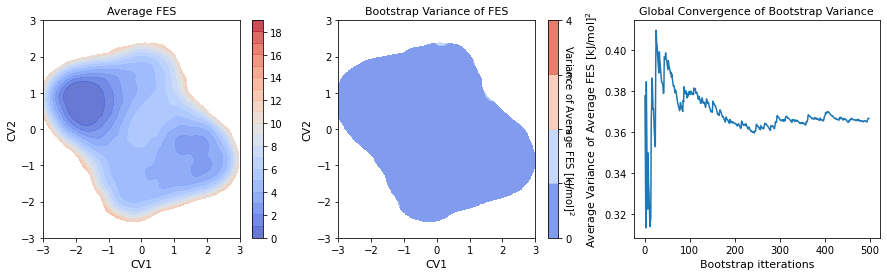

In [4]:
from pyMFI import MFI

#Find bootstrap error of 40 simulations

# # [FES_avr, cutoff, var_fes, sd_fes, variance_prog, stdev_prog, var_fes_prog, sd_fes_prog ] = MFI.bootstrap_2D(X, Y, forces_all, 100, FES_cutoff=20, min_grid=np.array((-3, -3)), max_grid=np.array((3, 3)))

import time
start = time.time()
[FES_avr, cutoff, sd_fes, sd_fes_prog ] = MFI.bootstrap_2D_fes(X, Y, forces_all, 500, FES_cutoff=20, min_grid=np.array((-3, -3)), max_grid=np.array((3, 3)))
print("Time for bootstrap", time.time() - start)

MFI.plot_bootstrap(X, Y, MFI.zero_to_nan(np.where(master_patch[-1][0] > 0.1, FES_avr, 0)), MFI.zero_to_nan(np.where(master_patch[-1][0] > 0.1, sd_fes, 0)), sd_fes_prog, FES_lim=20, ofe_lim=5)

In [5]:
MFI.save_pkl([X, Y, FES_avr, master_patch[-1][0], sd_fes, sd_fes_prog], results_path + "/invernizzi_multi_sim.pkl")

# [X, Y, FES_avr, Ftot_den, sd_fes, sd_fes_prog] = MFI.load_pkl(results_path + "/invernizzi_multi_sim.pkl")

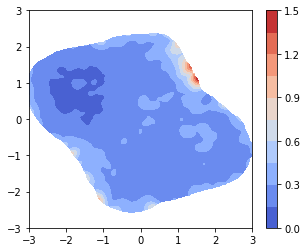

In [8]:
plt.contourf(X,Y,MFI.zero_to_nan(np.where(master_patch[-1][0] > 0.1, sd_fes, 0)), levels=np.linspace(0,1.5,11), cmap="coolwarm")
plt.colorbar()

#### (3) Some short simulations with HP